In [10]:
import sys
sys.path.append('../src')  # Adds the parent directory to the Python path
from astropy.io import fits
from astropy.wcs import WCS
from dfreproject import calculate_reprojection
from sunpy.data.sample import AIA_193_JUN2012, STEREO_A_195_JUN2012
import matplotlib.pyplot as plt
import torch
from astropy.io.fits import PrimaryHDU
from dfreproject import TensorHDU

In [11]:

def downscale_and_update_fits(source_hdu, target_hdu, target_wcs, downscale_size):

    # Downscale both images to downscale_size x downscale_size using torch (bilinear interpolation)
    def downscale_to_size(img, size):
        arr = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        arr_down = torch.nn.functional.interpolate(arr, size=(size, size), mode='bilinear', align_corners=False)
        return arr_down.squeeze().numpy()

    source_down = downscale_to_size(source_hdu.data, downscale_size)
    target_down = downscale_to_size(target_hdu.data, downscale_size)

    # Update FITS headers for new shape
    source_header = source_hdu.header.copy()
    target_header = target_hdu.header.copy()
    source_header['NAXIS1'] = downscale_size
    source_header['NAXIS2'] = downscale_size
    target_header['NAXIS1'] = downscale_size
    target_header['NAXIS2'] = downscale_size

    # Optionally update CDELT1/2 to preserve FOV (if desired)
    if 'CDELT1' in source_header and 'NAXIS1' in source_hdu.header:
        scale = source_hdu.header['NAXIS1'] / downscale_size
        source_header['CDELT1'] = source_hdu.header['CDELT1'] * scale
        source_header['CDELT2'] = source_hdu.header['CDELT2'] * scale
    if 'CDELT1' in target_header and 'NAXIS1' in target_hdu.header:
        scale = target_hdu.header['NAXIS1'] / downscale_size
        target_header['CDELT1'] = target_hdu.header['CDELT1'] * scale
        target_header['CDELT2'] = target_hdu.header['CDELT2'] * scale
    # Update CRPIX1/2 to match new image center after resizing
    if 'CRPIX1' in source_header and 'NAXIS1' in source_hdu.header:
        scale = source_hdu.header['NAXIS1'] / downscale_size
        source_header['CRPIX1'] = source_hdu.header['CRPIX1'] / scale
        source_header['CRPIX2'] = source_hdu.header['CRPIX2'] / scale
    if 'CRPIX1' in target_header and 'NAXIS1' in target_hdu.header:
        scale = target_hdu.header['NAXIS1'] / downscale_size
        target_header['CRPIX1'] = target_hdu.header['CRPIX1'] / scale
        target_header['CRPIX2'] = target_hdu.header['CRPIX2'] / scale

    new_source_hdu = TensorHDU(torch.tensor(source_down, dtype=torch.float64, requires_grad=True, device=torch.device("cpu")), source_header)
    new_target_hdu = PrimaryHDU(target_down, header=target_header)
    new_target_wcs = WCS(target_header)

    return new_source_hdu, new_target_hdu, new_target_wcs

torch.Size([2048, 2048])
True
tensor([[4.7533, 4.2316, 3.0126,  ..., 3.8816, 4.0438, 4.2647],
        [3.8887, 2.7438, 2.2698,  ..., 2.5023, 2.4245, 3.4351],
        [3.7407, 2.2585, 1.8996,  ..., 2.2776, 1.9588, 2.9889],
        ...,
        [3.0123, 2.5461, 2.2326,  ..., 2.4827, 2.4784, 3.0472],
        [2.4259, 2.3600, 2.0683,  ..., 2.1259, 2.1172, 3.0038],
        [5.6875, 3.5573, 2.8059,  ..., 3.6285, 3.1336, 4.4468]],
       dtype=torch.float64)


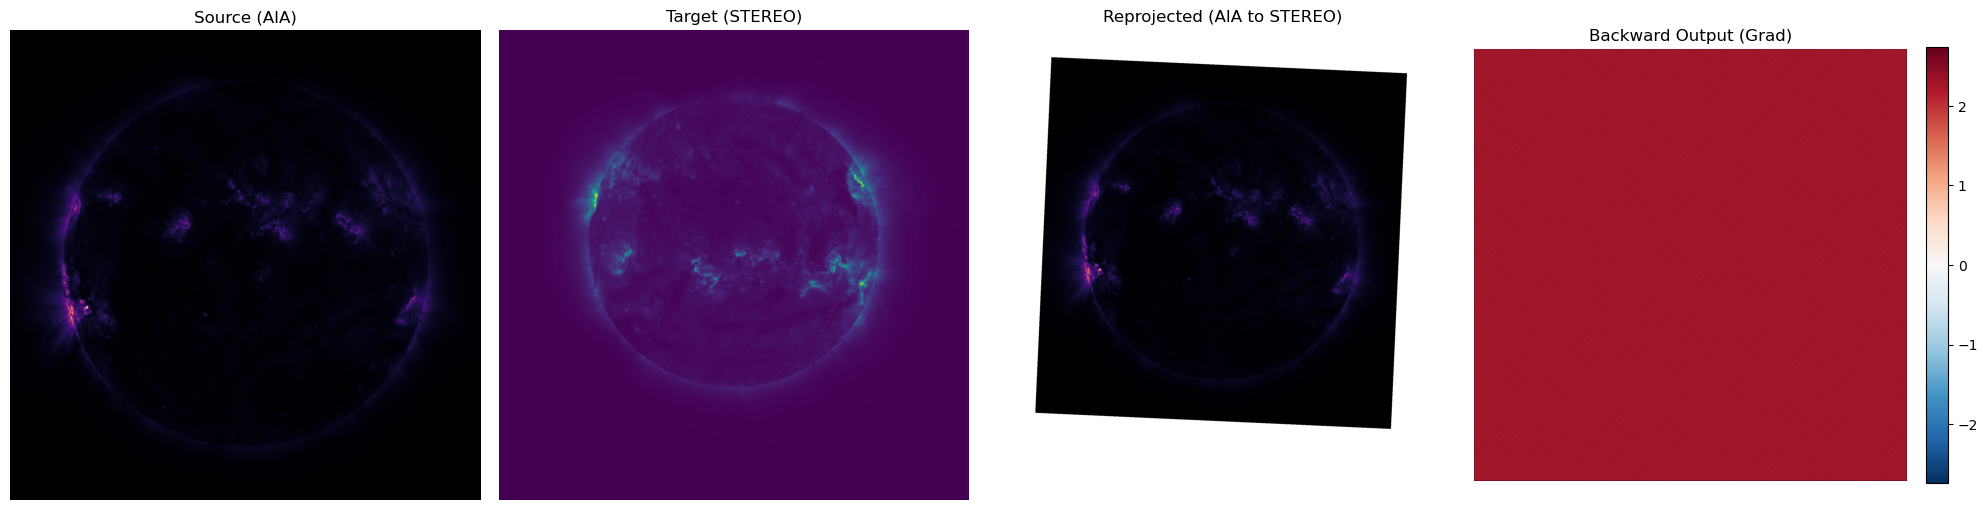

In [12]:
# Load source and target images
source_hdu = fits.open(AIA_193_JUN2012)[1]
target_hdu = fits.open(STEREO_A_195_JUN2012)[1]

# source_hdu = (torch.tensor(source_hdu.data, requires_grad=True), source_hdu.header)

source_hdu = TensorHDU(torch.tensor(source_hdu.data, requires_grad=True), source_hdu.header)
alt_tensor = source_hdu.tensor 
alt_header = source_hdu.header
target_hdu = PrimaryHDU(target_hdu.data, header=target_hdu.header)

target_wcs = WCS(target_hdu.header)
# Use the downscale_and_update_fits function defined above
downscale_size = 1024
# source_hdu, target_hdu, target_wcs = downscale_and_update_fits(source_hdu, target_hdu, target_wcs, downscale_size=downscale_size)




reprojected = calculate_reprojection(
    source_hdus=source_hdu,
    target_wcs=target_wcs,
    shape_out=target_hdu.data.shape,
    order='bilinear',
    requires_grad=True,
)



print(reprojected.shape)  # Should match target_hdu.data.shape



print(reprojected.requires_grad)  # Should be True if requires_grad=True was passed
reprojected.sum().backward()
print(source_hdu.tensor.grad)
# Plot with a diverging colormap centered at zero for gradients
import numpy as np

grad = source_hdu.tensor.grad.cpu().numpy()
# Use percentiles to avoid outlier-dominated color scaling
vmax = np.nanpercentile(np.abs(grad), 99)
if vmax == 0 or np.isnan(vmax):
    vmax = 1e-8  # fallback to avoid division by zero

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(source_hdu.data, cmap='magma')
axes[0].set_title('Source (AIA)')
axes[1].imshow(target_hdu.data, cmap='viridis')
axes[1].set_title('Target (STEREO)')
axes[2].imshow(reprojected.detach(), cmap='magma')
axes[2].set_title('Reprojected (AIA to STEREO)')
im = axes[3].imshow(grad, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
axes[3].set_title('Backward Output (Grad)')
for ax in axes:
    ax.axis('off')
fig.colorbar(im, ax=axes[3], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()